PLease Run the notebook in order 
some variables names used several times

# True Solution

In [3]:
def problem_cylinder(number,R):
    theta = np.linspace(0,2*np.pi,number)
    tracer_positions = np.zeros(number, dtype = complex)
    for i in range(number):
        tracer_positions[i] = complex(R*np.cos(theta[i]),R*np.sin(theta[i]))
    return tracer_positions

    
#def number of points at radius R outside the circle (points are tracer points)

In [4]:
tracer_positions = problem_cylinder(200,2)

NameError: name 'np' is not defined

In [5]:
def real_velocity(tracer_positions, v_inf,R):                                      #real solution
    real_vel = np.zeros(len(tracer_positions), dtype = complex)
    theta = np.linspace(0,2*np.pi,len(tracer_positions), False)
    for count,i in enumerate(theta):
        vx = (1-1/R**2)*v_inf*np.cos(i)**2 +(1+1/R**2)*v_inf*np.sin(i)**2
        vy = ((1-1/R**2)*v_inf -(1+1/R**2)*v_inf)*(np.sin(i)*np.cos(i))
        real_vel[count] = vx + 1j*vy
    return real_vel
        

In [6]:
real_vel = real_velocity(tracer_positions,1,2)

NameError: name 'tracer_positions' is not defined

# Constant Intensity Panel

In [7]:
import numpy as np
import math
import matplotlib.pyplot as plt 
import numba


In [8]:
def cylinder_panels(panels, R):                                  #Def panels at radius R and NUmber  = panels
    theta = np.linspace(0,2*math.pi,panels+1)
    start_points = np.zeros(panels, dtype = complex)
    end_points = np.zeros(panels, dtype = complex)
    
    start_points = np.cos(theta[:-1]) + 1j*np.sin(theta[:-1])
    end_points = np.cos(theta[1:]) + 1j*np.sin(theta[1:])
    return start_points, end_points


In [9]:
start_points,  end_points = cylinder_panels(30,1)

In [10]:
def dot(a,b):
    return a.real*b.real + a.imag*b.imag

In [11]:
A = matrix_A(start_points, end_points)

NameError: name 'matrix_A' is not defined

In [12]:
def matrix_A(start_points, end_points):                         #Calculation of matrix A
    n=len(start_points)
    A = np.zeros((n+1, n))
    normal = np.zeros(n, dtype = complex)
    normal = 1j*(start_points-end_points)/abs(start_points-end_points)
    for i in range(n):
        control_point = (start_points[i]+end_points[i])/2
        for j in range(n):
            if i!=j:
                panel_vector = end_points[j] -  start_points[j]
                length = abs(panel_vector)
                relative_vector = control_point - start_points[j]
                angle_panel = np.angle(panel_vector)
                conjugate_panel = (np.cos(angle_panel) - 1j*np.sin(angle_panel))
                relative_vector_at_angle = relative_vector*conjugate_panel
                velocity_mag = 1j*((np.log(1-length/relative_vector_at_angle))/(2*np.pi))
                velocity = (velocity_mag.conjugate())*(np.cos(angle_panel) + 1j*np.sin(angle_panel))
                A[i][j] = dot(normal[i], velocity)
    A[n]=1
    return A


In [13]:
def velocity_dueto_vortices(control_point, gammas, positions):              #velocity due to vortices present in flow
    velocity_due_vortices = (0+1j*0)
    for i in range(len(gammas)):
        z_relative = control_point - positions[i]
        v_conjugate = complex(0,-1)*(gammas[i])/(2*(np.pi)*(z_relative))
        velocity  = v_conjugate.conjugate()
        velocity_due_vortices += velocity
        return velocity_due_vortices
        
        

In [14]:
def matrix_b(start_points, end_points,velocity_body=complex(0), gammas=0, positions=0, v_inf=0):
    n = len(start_points)
    v=np.zeros(n, dtype = complex)
    normal=np.zeros(n, dtype = complex)
    normal = 1j*(start_points-end_points)/abs(start_points-end_points)
    for i in range(n):
        control_point = (start_points[i]+end_points[i])/2
        if gammas !=0:
            velocity_due_vortices = velocity_dueto_vortices(control_point,gammas,positions)
        else:
            velocity_due_vortices = 0
        v[i] = velocity_body - (v_inf+1j*0) - velocity_due_vortices
        b = dot(v,normal)
    b= np.append(b,0)
    return b

#mateix b calculation, take start points, end_points, Velocity of bofy, gammas of vortices present in flow
#positions of vortices , velocity of free streams
    

In [15]:
b = matrix_b(start_points, end_points, v_inf = 1)

In [16]:
def solve(A,b):
        ans = np.linalg.lstsq(A, b, rcond=None)[0]
        return ans

In [17]:
circulations = solve(A,b)

NameError: name 'A' is not defined

In [18]:
def problem_cylinder(number,R):
    theta = np.linspace(0,2*np.pi,number)
    tracer_positions = np.zeros(number, dtype = complex)
    for i in range(number):
        tracer_positions[i] = complex(R*np.cos(theta[i]),R*np.sin(theta[i]))
    return tracer_positions
    
#def number of points at radius R outside the circle (points are tracer points)

In [19]:
tracer_positions = problem_cylinder(200,2)

In [20]:
@numba.njit
def velocity_tracer(tracer_position, start_point, end_point, circulation):
    panel_vector = end_point - start_point
    length = abs(panel_vector)
    relative_vector = tracer_position - start_point
    angle_panel = panel_vector/length
    conjugate_panel = angle_panel.conjugate()
    relative_vector_at_angle = relative_vector*conjugate_panel
    velocity_mag = (1j*circulation*(np.log((relative_vector_at_angle-length)/relative_vector_at_angle)))/(2*np.pi)
    velocity = (velocity_mag.conjugate())*angle_panel
    return velocity

#velocity of Particles present outside the cylinder due to one panel

In [21]:
@numba.njit
def total_velocity_tracer(tracer_positions, start_points, end_points, circulations,v,v_inf=0):
    for i in range(len(tracer_positions)):
        for j in range(len(start_points)):
            v[i]+=velocity_tracer(tracer_positions[i],start_points[j], end_points[j], circulations[j])
        v[i]+= (v_inf + 1j*0)
    return v
            
#velocity of all particles due to all panels and free stream

In [22]:
v=np.zeros(len(tracer_positions),dtype = complex)
exp_velocity = total_velocity_tracer(tracer_positions, start_points, end_points, circulations,v, v_inf=1)

NameError: name 'circulations' is not defined

In [23]:
def error(real_velocity, exp_velocity):
    n = len(real_velocity)
    s = abs(real_velocity - exp_velocity)/abs(real_velocity)
    error = sum(s)*100/n
    return error

#error calcualtion

In [24]:
err = error(real_vel, exp_velocity)

NameError: name 'real_vel' is not defined

In [25]:
err

NameError: name 'err' is not defined

Error Trend After Variying R and Number of panels Both

In [26]:
error_trend = []
# tracer_positions = problem_cylinder(200,2)
for i in range(50,151,20):
    temp_error = []
    for j in range(2,11,2):
        temp_tracer_positions = problem_cylinder(200,j)
        temp_real_vel = real_velocity(temp_tracer_positions,1,j)
        start_points,  end_points = cylinder_panels(i,1)
        A = matrix_A(start_points, end_points)
        b = matrix_b(start_points, end_points, v_inf = 1)
        circulations = solve(A,b)
        v=np.zeros(len(temp_tracer_positions),dtype = complex)
        exp_velocity = total_velocity_tracer(temp_tracer_positions, start_points, end_points, circulations,v, v_inf=1)
        temp_error.append(error(temp_real_vel, exp_velocity))
    error_trend.append(temp_error)
    
    

In [27]:
# error_trend

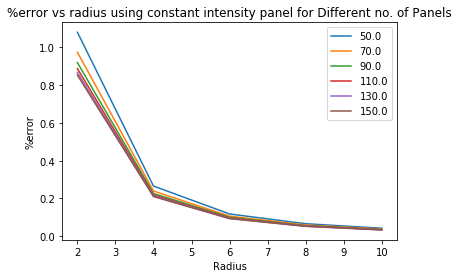

In [28]:
radius = np.linspace(2,10,5)
number_panel = np.linspace(50,150,6)
for i in range(len(number_panel)):
    plt.plot(radius,error_trend[i],label = number_panel[i])
    plt.legend()
    plt.xlabel("Radius")
    plt.ylabel("%error")
    plt.title("%error vs radius using constant intensity panel for Different no. of Panels")

# Lineaer Intensity Panel

In [29]:
def cylinder_panels(panels, R):
    theta = np.linspace(0,2*math.pi,panels+1)
    start_points = np.zeros(panels, dtype = complex)
    end_points = np.zeros(panels, dtype = complex)
    
    start_points = np.cos(theta[:-1]) + 1j*np.sin(theta[:-1])
    end_points = np.cos(theta[1:]) + 1j*np.sin(theta[1:])
    return start_points, end_points


#def panels

In [30]:
start_points,  end_points = cylinder_panels(100,1)

In [31]:
def dot(a,b):
    return a.real*b.real + a.imag*b.imag

In [32]:
def matrix_A_linear(start_points, end_points):
    n = len(start_points)
    noraml = 1j*(start_points-end_points)/abs(start_points-end_points)
    A = np.zeros((n+1, n))
    for i in range(n):
        control_point = (end_points[i]+start_points[i])/2
        for j in range(n):
            panel_vector = end_points[j]-start_points[j]
            l = abs(panel_vector)
            relative_vector = control_point - start_points[j]
            angle_panel = panel_vector/l
            conjugate_panel = angle_panel.conjugate()
            rva = relative_vector*conjugate_panel
            vel1 = -1j*(((rva/l)-1)*(np.log(1-(l/rva)))+1)
            vel2 = 1j*((rva/l)*(np.log(1-(l/rva)))+1)
            v1 = (vel1.conjugate())*angle_panel
            v2 = (vel2.conjugate())*angle_panel
            if j!= n-1:
                A[i][j]+=dot(v1,noraml[i])
                A[i][j+1]+=dot(v2,noraml[i])
            elif j == n-1:
                A[i][j]+=dot(v1,noraml[i])
                A[i][0]+=dot(v2,noraml[i])
    A[n]= 1
    return A
                
#matrix A (cofficients of gammas of panels) using standerd formulae

In [33]:
def matrix_b(start_points, end_points,velocity_body=0, gammas=0, positions=0, v_inf=0):
    n = len(start_points)
    v=np.zeros(n, dtype = complex)
    normal=np.zeros(n, dtype = complex)
    normal = 1j*(start_points-end_points)/abs(start_points-end_points)
    for i in range(n):
        control_point = (start_points[i]+end_points[i])/2
        if gammas !=0:
            velocity_due_vortices = velocity_dueto_vortices(control_point,gammas,positions)
        else:
            velocity_due_vortices = 0
        v[i] = velocity_body - v_inf - velocity_due_vortices
        b = dot(v,normal)
    b= np.append(b,0)
    return b
        
#remain same as in prevoius

In [34]:
A_linear = matrix_A_linear(start_points, end_points)
b_linear = matrix_b(start_points, end_points, v_inf=1)

In [35]:
def solve(A,b):
        ans = np.linalg.lstsq(A, b, rcond=None)[0]
        return ans

In [36]:
circulations_linear = solve(A_linear,b_linear)

In [37]:
def velocity_tracer_linear(tracer_position, start_point, end_point, circulation):
    panel_vector = end_point-start_point
    l = abs(panel_vector)
    control_point = (start_point+end_point)/2
    relative_vector = tracer_position - start_point
    angle_panel = panel_vector/l
    conjugate_panel = angle_panel.conjugate()
    rva = relative_vector*conjugate_panel
    vel1 = -1j*(circulation)*(((rva/l)-1)*(np.log(1-(l/rva)))+1)
    vel2 = 1j*(circulation)*((rva/l)*(np.log(1-(l/rva)))+1)
    v1 = (vel1.conjugate())*angle_panel
    v2 = (vel2.conjugate())*angle_panel
    velocity = v1 + v2
    return velocity

#velocity function of particle outside cylinder using linear intensity panel discretization

In [38]:
def total_velocity_tracer_linear(tracer_positions, start_points, end_points, circulations_linear,v,v_inf=0):
    for i in range(len(tracer_positions)):
        for j in range(len(start_points)):
            v[i] += velocity_tracer_linear(tracer_positions[i],start_points[j], end_points[j], circulations_linear[j])
        v[i]+= (v_inf + 1j*0)
    return v
            
#velocity of all particles due to all panels, free stream

In [39]:
def problem_cylinder(number,R):
    theta = np.linspace(0,2*np.pi,number)
    tracer_positions = np.zeros(number, dtype = complex)
    for i in range(number):
        tracer_positions[i] = complex(R*np.cos(theta[i]),R*np.sin(theta[i]))
    return tracer_positions
    
#def points outside the cylinder

In [40]:
tracer_positions = problem_cylinder(200,2)


In [41]:
v=np.zeros(len(tracer_positions),dtype = complex)
exp_velocity = total_velocity_tracer_linear(tracer_positions, start_points, end_points, circulations_linear,v, v_inf=1)

In [42]:
def error(real_velocity, exp_velocity):
    n = len(real_velocity)
    s = abs(real_velocity - exp_velocity)/abs(real_velocity)
    error = (sum(s)*100)/n
    return error

#error calculation

In [43]:
err = error(real_vel, exp_velocity)

NameError: name 'real_vel' is not defined

In [44]:
err


NameError: name 'err' is not defined

Error Trend After Variying R and Number of panels Both

In [45]:
error_trend_linear = []
# tracer_positions = problem_cylinder(200,2)
for i in range(50,151,20):
    temp_error_linear = []
    for j in range(2,11,2):
        temp_tracer_positions = problem_cylinder(200,j)
        temp_real_vel = real_velocity(temp_tracer_positions,1,j)
        start_points,  end_points = cylinder_panels(i,1)
        A_linear = matrix_A_linear(start_points, end_points)
        b_linear = matrix_b(start_points, end_points, v_inf = 1)
        circulations_linear = solve(A_linear,b_linear)
        v=np.zeros(len(temp_tracer_positions),dtype = complex)
        exp_velocity = total_velocity_tracer_linear(temp_tracer_positions, start_points, end_points, circulations_linear,v, v_inf=1)
        temp_error_linear.append(error(temp_real_vel, exp_velocity))
    error_trend_linear.append(temp_error_linear)
    
    

In [46]:
# error_trend_linear

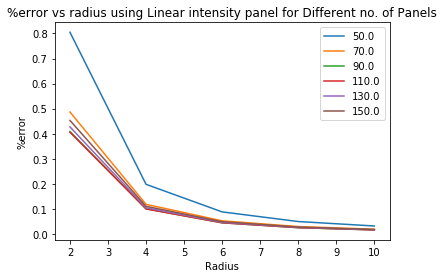

In [47]:
radius = np.linspace(2,10,5)
number_panel = np.linspace(50,150,6)
for i in range(len(number_panel)):
    plt.plot(radius,error_trend_linear[i],label = number_panel[i])
    plt.legend()
    plt.xlabel("Radius")
    plt.ylabel("%error")
    plt.title("%error vs radius using Linear intensity panel for Different no. of Panels")

# Path of Vortex 

1. Using Constant Panel

In [48]:
def euler(tracer_positions, start_points, end_points, circulations, dt):
    new_positions = np.zeros(shape=(len(tracer_positions)),dtype=complex)
    v=np.zeros(len(tracer_positions),dtype=complex)
    velocity = total_velocity_tracer(tracer_positions, start_points, end_points, circulations,v )
    for i in range(len(tracer_positions)):
        new_positions[i] = tracer_positions[i] + velocity[i]*dt
    return new_positions

In [49]:
def RK2(tracer_positions, start_points, end_points, circulations, dt):
    new_positions = np.zeros(shape=(len(tracer_positions)),dtype=complex)
    v=np.zeros(len(tracer_positions),dtype=complex)
    vi = total_velocity_tracer(tracer_positions,start_points, end_points,circulations, v)
    temp_positions = euler(tracer_positions, start_points, end_points, circulations, dt)
    vi1 = total_velocity_tracer(temp_positions, start_points, end_points, circulations,v)
    for i in range(len(tracer_positions)):
        new_positions[i] = tracer_positions[i] + (vi[i]+vi1[i])*dt/2
    return new_positions

In [50]:
start_points,  end_points = cylinder_panels(100,1)

In [51]:
A_voretx = matrix_A(start_points, end_points)

In [52]:
gammas = np.array([2*np.pi])
positions = np.array([1.5*np.cos(np.pi/4)+1j*(1.5*np.sin(np.pi/4))])

In [53]:
b_vortex = matrix_b(start_points, end_points,gammas= gammas, positions=positions)

In [54]:
circulations_vortex = solve(A_voretx, b_vortex)

In [55]:
def integrate(tracer_positions, circulations, start_points, end_points,steps, dt, method=1):
    data = []
    data.append(tracer_positions)
    temp_positions = tracer_positions
    if method == 1 :
        for i in range(1,steps,1):
            new_positions = RK2(temp_positions, start_points, end_points, circulations, dt)
             #print(new_positions)
            data.append(new_positions)
            temp_positions = new_positions
            A_voretx = matrix_A(start_points, end_points)
            gammas = np.array([2*np.pi])
            b_vortex = matrix_b(start_points, end_points,gammas= gammas, positions=temp_positions)
            circulations = solve(A_voretx, b_vortex)

    return data   
    
    

In [56]:
data = integrate(positions, circulations_vortex, start_points, end_points,100,0.01)

In [57]:
eta=np.linspace(0,2*np.pi,100)
p=np.cos(eta)
q=np.sin(eta)

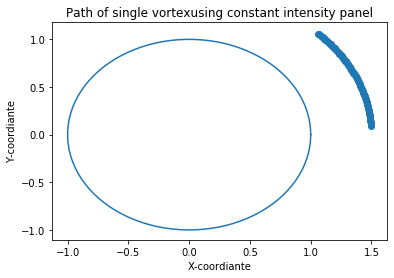

In [58]:
plt.scatter(np.array(data).real, np.array(data).imag)
plt.plot(p,q)
plt.xlabel("X-coordiante")
plt.ylabel("Y-coordiante")
plt.title("Path of single vortexusing constant intensity panel")
plt.savefig("vcip")

2   Using Linear Intensity Panels

In [59]:
b_vortex_linear = matrix_b(start_points, end_points,gammas= gammas, positions=positions)

In [60]:
A_voretx_linear = matrix_A_linear(start_points, end_points)

In [61]:
circulations_vortex_linear = solve(A_voretx, b_vortex)

In [62]:
def euler_linear(tracer_positions, start_points, end_points, circulations, dt):
    new_positions = np.zeros(shape=(len(tracer_positions)),dtype=complex)
    v=np.zeros(len(tracer_positions),dtype=complex)
    velocity = total_velocity_tracer_linear(tracer_positions, start_points, end_points, circulations,v )
    for i in range(len(tracer_positions)):
        new_positions[i] = tracer_positions[i] + velocity[i]*dt
    return new_positions

def RK2_linear(tracer_positions, start_points, end_points, circulations, dt):
    new_positions = np.zeros(shape=(len(tracer_positions)),dtype=complex)
    v=np.zeros(len(tracer_positions),dtype=complex)
    vi = total_velocity_tracer_linear(tracer_positions,start_points, end_points,circulations, v)
    temp_positions = euler_linear(tracer_positions, start_points, end_points, circulations, dt)
    vi1 = total_velocity_tracer_linear(temp_positions, start_points, end_points, circulations,v)
    for i in range(len(tracer_positions)):
        new_positions[i] = tracer_positions[i] + (vi[i]+vi1[i])*dt/2
    return new_positions

In [63]:
def integrate(tracer_positions, circulations, start_points, end_points,steps, dt, method=1):
    data = []
    data.append(tracer_positions)
    temp_positions = tracer_positions
    if method == 1 :
        for i in range(1,steps,1):
            new_positions = RK2_linear(temp_positions, start_points, end_points, circulations, dt)
             #print(new_positions)
            data.append(new_positions)
            temp_positions = new_positions
            A_voretx = matrix_A_linear(start_points, end_points)
            gammas = np.array([2*np.pi])
            b_vortex = matrix_b(start_points, end_points,gammas= gammas, positions=temp_positions)
            circulations = solve(A_voretx, b_vortex)
    return data   
    
    

In [64]:
data_linear = integrate(positions, circulations_vortex_linear, start_points, end_points,100,0.01)

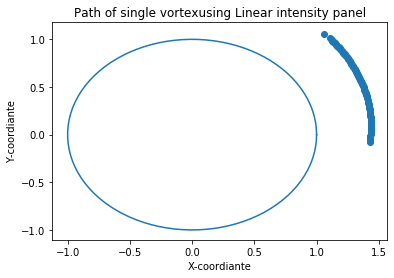

In [65]:
plt.scatter(np.array(data_linear).real, np.array(data_linear).imag)
plt.plot(p,q)
plt.xlabel("X-coordiante")
plt.ylabel("Y-coordiante")
plt.title("Path of single vortexusing Linear intensity panel")
plt.savefig("vlip")

In [66]:
diff  = sum(((np.abs((np.array(data_linear)-np.array(data)))/np.abs(np.array(data_linear)))))

In [67]:
diff                                         #percentage difference between using method linear vs constant 
                                               # intensity panel

array([6.4291549])

3 Using the image Method

In [68]:
gamma = np.array([2*np.pi,2*np.pi,-2*np.pi])

In [69]:
def reflected_pos(a,z):
    pos = a**2/(z.conjugate())
    return pos
    

In [70]:
@numba.njit
def get_velocity(circulation, self_position, other_position):       #velocity due to point vortices
    v_conjugate = complex(0,-1)*(circulation)/(2*(np.pi)*(self_position-other_position))
    velocity  = v_conjugate.conjugate()
    return velocity

In [71]:
@numba.njit
def total_velocity(gamma, all_positions,v):                          #velocity of all vortices due to others
    for i in range(len(gamma)):
        for j in range(len(gamma)):
            if i!=j:
                v[i] += get_velocity(gamma[j],all_positions[i],all_positions[j])
    return v

In [72]:
initial_position = np.array([1.5*np.cos(np.pi/4)+1j*(1.5*np.sin(np.pi/4))])

In [73]:
positions = np.array([initial_position[0],complex(0,0),reflected_pos(1,initial_position[0])])

In [74]:
def euler(gamma, all_positions, dt):                            #euler function for position update
    new_positions = np.zeros(shape=(len(gamma)),dtype=complex)
    v=np.zeros(len(gamma),dtype=complex)
    velocity = total_velocity(gamma, all_positions,v)
    for i in range(len(gamma)):
        new_positions[i] = all_positions[i] + velocity[i]*dt
    x= np.array([new_positions[0], complex(0,0,),reflected_pos(1,initial_position[0])])
    return x

def RK2(gamma, all_positions, dt):                              #RK2 for position update
    new_positions = np.zeros(shape=(len(gamma)),dtype=complex)
    v=np.zeros(len(gamma),dtype=complex)
    vi = total_velocity(gamma, all_positions,v)
    temp_positions = euler(gamma, all_positions, dt)
    vi1 = total_velocity(gamma, temp_positions,v)
    for i in range(len(gamma)):
        new_positions[i] = all_positions[i] + (vi[i]+vi1[i])*dt/2
    return new_positions


In [75]:
def integrate(gamma, all_positions, n, dt, method):             #integrater for RK2 And Euler 
                                                                #merthod =1 for RK2 AND 2 for Euler
    data = []                                                   #gamma and all_positions are vorticity and 
                                                                #positions of all point vortices
    data.append(all_positions[0])                                  #dt is time step, n = number of steps
    temp_positions = all_positions
    if method==1 :
        for i in range(1,n,1):
            new_positions = RK2(gamma,temp_positions, dt)
            data.append(new_positions[0])
            temp_positions = np.array([new_positions[0], complex(0,0,),reflected_pos(1,new_positions[0])])
    return data

In [76]:
data_image = integrate(gamma, positions,100,0.01,1)

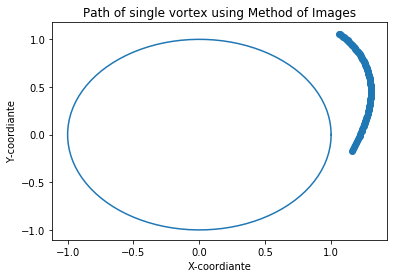

In [77]:
plt.scatter(np.array(data_image).real, np.array(data_image).imag)
plt.plot(p,q)
plt.xlabel("X-coordiante")
plt.ylabel("Y-coordiante")
plt.title("Path of single vortex using Method of Images")
plt.savefig("vmoi")

In [78]:
d=np.reshape(data_image,(100,1))

In [79]:
sum(abs(d-data_linear)/abs(d))                             #percentage error with linear intensity panel vs image method

array([8.36077434])

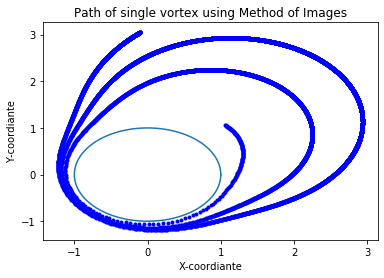

In [80]:
data_image1 = integrate(gamma, positions,10000,0.01,1)
plt.plot(np.array(data_image1).real, np.array(data_image1).imag,"b.")
plt.plot(p,q)
plt.xlabel("X-coordiante")
plt.ylabel("Y-coordiante")
plt.title("Path of single vortex using Method of Images")
plt.savefig("vmoi1")